### Tasks - project 4

Identifying regulatory interactions
Single cell RNA sequencing data allows the measurement of all genes in many cells at the same time. Genes are often co-regulated, or regulate each other. Correlation, anti-correlation or mutual information between pairs of genes can hint regulatory interactions, and help in reconstructing regulatory networks.

*	Background single cell RNA sequencing
*	Data – any single cell RNA-sequencing data.
*	Filter out genes that are not expressed
*	Replace values lower than one by one. log2 transform the data
*	Identify pairs of genes that are significantly correlated (alternatively, anti-correlated or have mutual information). Take into account the problem of multiple comparisons
*	Test if those gene pairs are also correlated in the other dataset. 
*	For at least one correlated pair of genes, see if you can find research about interaction or functional relationships between those genes. 


# The Libraries

In [20]:
from sys import getsizeof
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import mutual_info_score
from scipy.stats.stats import pearsonr   
import matplotlib.pyplot as plt
%matplotlib inline




# Functions

In [49]:
def calc_MI(x, y, bins=12):
    c_xy = np.histogram2d(x, y, bins)[0]
    mi = mutual_info_score(None, None, contingency=c_xy)
    return mi

def pre_log2(df):
    for gene in df:
        for ind, val in df[gene].iteritems():
            if val <= 1:
                df.set_value(index=ind, col=gene, value=0)
            elif val > 1:
                df.set_value(index=ind, col=gene, value=np.log2(val))
    return df

def remove_zero_genes(mode, trsh=40):
    cnt = 0
    zeros = []
    for col in tqdm(df):
        if mode == 'zero':
            if (df[col].values < 1).all():
                cnt += 1
                zeros.append(col)            
        elif mode == 'sparse':
            if np.sum((df[col].values > 1)) < 40:        
                cnt += 1
                zeros.append(col)
    print '# removed columns = ', cnt
    df.drop(zeros, axis=1, inplace=True)
    return df

In [6]:
x, y = range(1000), range(1000)

calc_MI(x, y, 10)

2.302585092994045

In [7]:
% ls data/

GSE81383_data_melanoma_scRNAseq_BT_Mel.txt
GSE82187_cast_all_forGEO.csv
GSE83533_AML_130_Rel_rpkm.txt
unused/


In [267]:
!du -h data/GSE83533_AML_130_Rel_rpkm.txt

9.1M	data/GSE83533_AML_130_Rel_rpkm.txt


# Reading the data

In [86]:
path = '/Users/mdymshits/comp_bio/data/GSE83533_AML_130_Rel_rpkm.txt'
df = pd.read_csv(path, delimiter='\t')

## Small preprocessing:
### like transpose 
### removing some headers
### issue with duplicate genes

In [87]:
df = df.iloc[:, 1:].T
df.columns = df.iloc[0]
df = df.reindex(df.index.drop('gene'))
df.reset_index(inplace=True)
df.drop('index', axis=1, inplace=True)
df.columns = ['_'.join([col, str(i)]) for i, col in enumerate(df.columns)]
df.iloc[:10,:10]

,TAF1L_0,RNU6-69_1,ROCK1_2,SNORD115-42_3,OR8B2_4,LYN_5,SNORD115-43_6,OR8B3_7,OR2AT4_8,KCTD14_9
0,0,0,40.0059,0,0,4.95385,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0
2,0,0,70.5803,0,0,2.86212,0,0,0,0
3,0,0,24.1233,0,0,144.22,0,0,0,0
4,0,0,2.9105,0,0,0.665994,0,0,0,0
5,0,0,0.0638631,0,0,0,0,0,0,0
6,0,0,29.135,0,0,0,0,0,0,0
7,0,0,80.7414,0,0,0,0,0,0,0
8,0,0,22.4341,0,0,1.01223,0,0,0,0
9,0,0,11.2208,0,0,6.37025,0,0,0,0


(0, 25000)

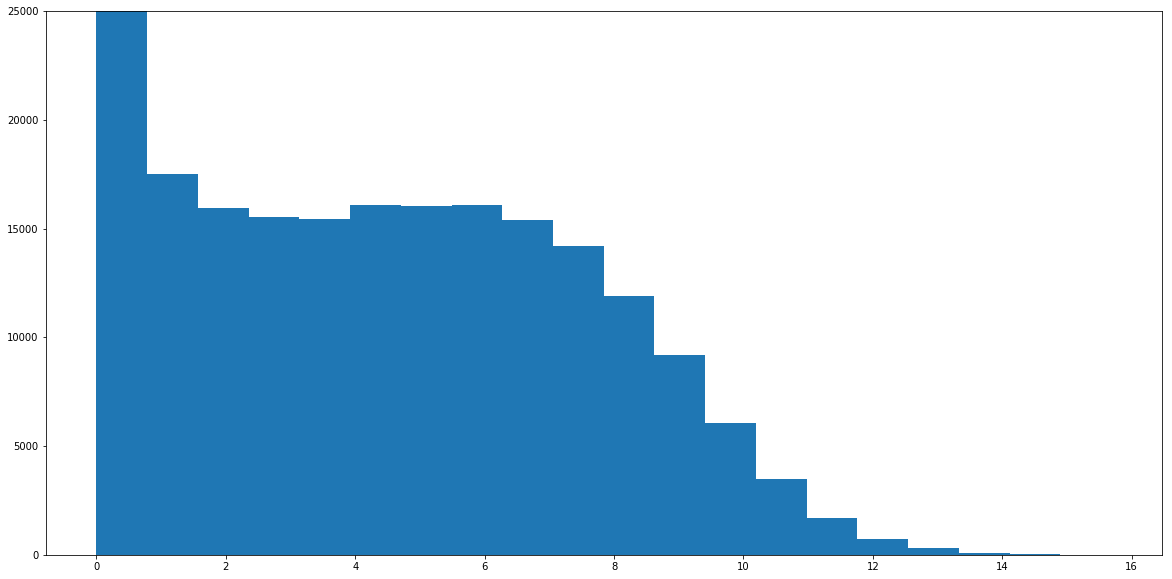

In [45]:
plt.figure(figsize=(20, 10))
# bins = np.linspace(0, .25, 20)
plt.hist(df.values.ravel(), bins=20);
# plt.xlim(0, 20)
plt.ylim(0, 25000)


# Preprocessing with $log_2$

In [88]:
%time df = pre_log2(df)
           

CPU times: user 9.24 s, sys: 257 ms, total: 9.49 s
Wall time: 9.48 s


23737it [00:00, 78691.89it/s]         


# removed columns =  10773


(0, 20000)

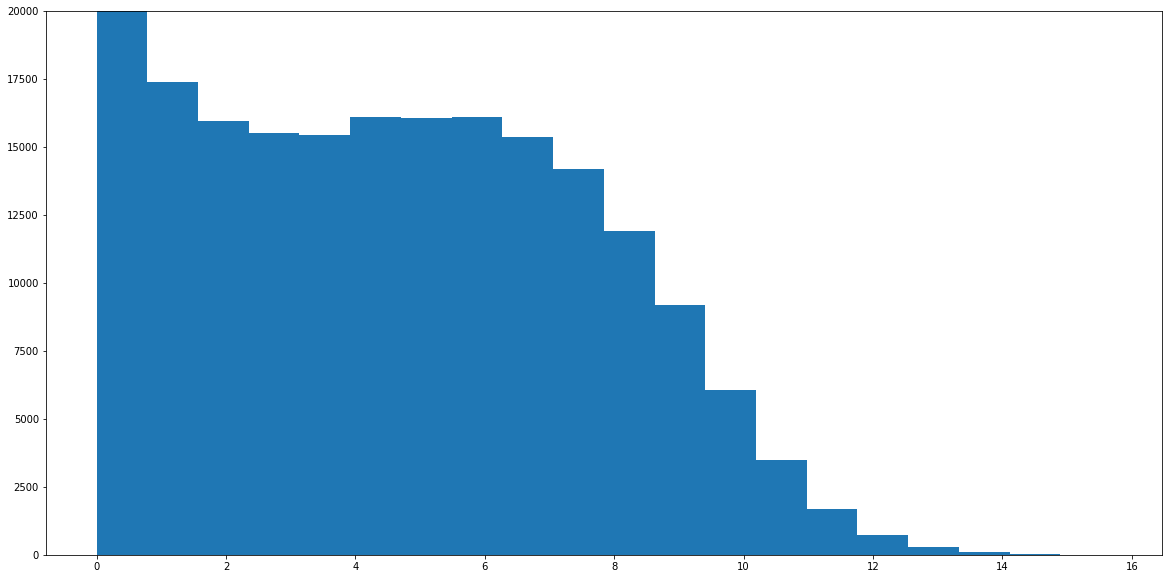

In [89]:
df = remove_zero_genes(mode='zero')
col_names = df.columns
plt.figure(figsize=(20, 10))
plt.hist(df.values.ravel(), bins=20);
plt.ylim(0, 20000)


In [90]:
df.shape

(96, 12964)

In [91]:
%%time
cor = np.corrcoef(df.values.astype(dtype='float').T)

CPU times: user 3.56 s, sys: 377 ms, total: 3.94 s
Wall time: 3.39 s


In [92]:
cor.shape

(12964, 12964)

In [137]:
cor_genes = {}
for i in tqdm(range(cor.shape[0])):
    for j in range(cor.shape[0]):
        if j >= i:
            continue
        if abs(cor[i,j]) > .99:
            cor_genes['__'.join([col_names[i], col_names[j]])] = cor[i,j]
#             print cor[i,j], col_names[i], col_names[j]

100%|██████████| 12964/12964 [00:36<00:00, 356.71it/s]


In [138]:
len(cor_genes)

23953

In [140]:
non_cor_genes = {}
for i in tqdm(range(cor.shape[0])):
    for j in range(cor.shape[0]):
        if j >= i:
            continue
        if abs(cor[i,j]) < .001:
            non_cor_genes['__'.join([col_names[i], col_names[j]])] = cor[i,j]


100%|██████████| 12964/12964 [00:37<00:00, 342.86it/s]


In [141]:
len(non_cor_genes) / 10. ** 4

34.5231

In [98]:
nbins = 12

In [142]:
mi_no_corr = []
for i, key in enumerate(non_cor_genes):
    gen1, gen2 = key.split('__')
#     print gen1, gen2
    val = calc_MI(df[gen1].values.astype(dtype='float'),
                  df[gen2].values.astype(dtype='float'),
                                             bins=nbins)
    mi_no_corr.append(val)
#     print gen1, gen2, val
    
    if i > 5000:
        break
# print mi
print np.mean(mi_no_corr), np.std(mi_no_corr)   

0.101354666271 0.0827982450041


In [143]:
mi_corr = {}
for i, key in enumerate(cor_genes):
    gen1, gen2 = key.split('__')
    val = calc_MI(df[gen1].values.astype(dtype='float'),
                  df[gen2].values.astype(dtype='float'),
                                            bins=nbins)
    mi_corr['__'.join([gen1, gen2])] = val

print np.mean(mi_corr.values()), np.std(mi_corr.values())


0.0580468805792 0.00288444841184


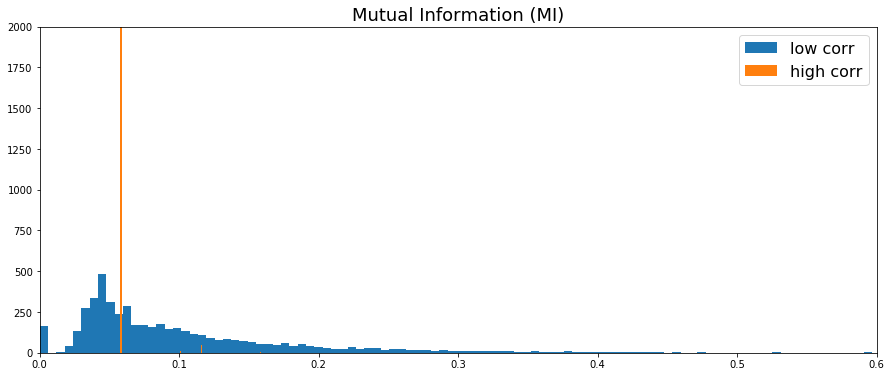

In [148]:
plt.figure(figsize=(15, 6))
# plt.subplot(1,2,1)
plt.hist(mi_no_corr, bins= 100, label='low corr');
plt.title('Mutual Information (MI)', fontsize=18)
# plt.subplot(1,2,2)
plt.hist(mi_corr.values(), bins=100, label='high corr');
plt.xlim(0,.6)
plt.ylim(0,2 * 10 **3)
plt.legend(fontsize=16)

In [101]:
pearsonr(df['C14orf182_14784'].values, df['SCAMP4_1724'].values)


(0.99999290097138094, 1.1719553056952381e-229)

In [147]:
for i, j in zip(df['C14orf182_14784'].values, df['SCAMP4_1724'].values):
    print i, j

0 0
0 0.0215222755888
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
5.83138113446 5.71168935272
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
